# Submit jobs to cubic

In [3]:
import os
import numpy as np
import subprocess
import json

py_exec = '/cbica/home/parkesl/miniconda3/envs/neurodev_cs_predictive/bin/python'
indir = '/cbica/home/parkesl/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/schaefer_200_streamlineCount/predict_pheno'

metrics = ['vol', 'str', 'ac', 'mc']
phenos = ['Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear']
# phenos = ['F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy', 'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
#           'F2_Memory.Efficiency', 'F3_Executive_Efficiency', 'F4_Social_Cognition_Efficiency']
algs = ['rr', 'lr', 'krr_lin', 'krr_rbf', 'svr_rbf']
scores = ['r2', 'corr', 'mse']

num_algs = len(algs)
num_metrics = len(metrics)
num_phenos = len(phenos)
num_scores = len(scores)

# print(num_seeds * num_algs * num_metrics * num_phenos)
print(num_algs * num_metrics * num_phenos * num_scores)

36000


## Stratified cross-val

In [1]:
py_script = '/cbica/home/parkesl/ResProjects/neurodev_cs_predictive/code/cluster/predict_pheno_scv.py'
outdir = os.path.join(indir, 'stratified_null')

In [ ]:
for alg in algs:
    for metric in metrics:
        for pheno in phenos:
            for score in scores:
                subprocess_str = '{0} {1} -x {2}/X.csv -y {2}/y.csv -alg {3} -metric {4} -pheno {5} -score {6} -o {7}'.format(py_exec, py_script, indir, alg, metric, pheno, score, outdir)

                name = alg + '_' + metric + '_' + pheno + '_' + score
                qsub_call = 'qsub -N {0} -l h_vmem=1G,s_vmem=1G -pe threaded 4 -j y -b y -o /cbica/home/parkesl/sge/ -e /cbica/home/parkesl/sge/ '.format(name)

                os.system(qsub_call + subprocess_str)

## Assemble outputs

In [ ]:
for score in scores:
    workdir = os.path.join(outdir, score)
    print(score)
    
    accuracy = np.zeros((num_algs, num_metrics, num_phenos))
    permuted_acc = np.zeros((num_algs, num_metrics, num_phenos, 5000))

    for a, alg in enumerate(algs):
        for m, metric in enumerate(metrics):
            for p, pheno in enumerate(phenos):
                accuracy[a,m,p] = np.loadtxt(os.path.join(workdir, alg + '_' + metric + '_' + pheno, 'best_score.txt'))
                permuted_acc[a,m,p,:] = np.loadtxt(os.path.join(workdir, alg + '_' + metric + '_' + pheno, 'permuted_acc.txt'))

    np.save(os.path.join(workdir, 'accuracy'), accuracy)
    np.save(os.path.join(workdir, 'permuted_acc'), permuted_acc)

## Random splits cross-val

In [ ]:
py_script = '/cbica/home/parkesl/ResProjects/neurodev_cs_predictive/code/cluster/predict_pheno.py'
outdir = os.path.join(indir, 'random_splits')

In [ ]:
for alg in algs:
    for metric in metrics:
        for pheno in phenos:
            for score in scores:
                subprocess_str = '{0} {1} -x {2}/X.csv -y {2}/y.csv -alg {3} -metric {4} -pheno {5} -score {6} -o {7}'.format(py_exec, py_script, indir, alg, metric, pheno, score, outdir)

                name = alg + '_' + metric + '_' + pheno + '_' + score
                qsub_call = 'qsub -N {0} -l h_vmem=1G,s_vmem=1G -t 1-100 -pe threaded 4 -j y -b y -o /cbica/home/parkesl/sge/ -e /cbica/home/parkesl/sge/ '.format(name)

                os.system(qsub_call + subprocess_str)

## Assemble outputs

In [ ]:
seeds = np.arange(0,100)
num_seeds = len(seeds)

for score in scores:
    workdir = os.path.join(outdir, 'main_score_'+score)
    print(score)
    
    nested_score_mean = np.zeros((num_seeds, num_algs, num_metrics, num_phenos))
    non_nested_r2 = np.zeros((num_seeds, num_algs, num_metrics, num_phenos))
    non_nested_mse = np.zeros((num_seeds, num_algs, num_metrics, num_phenos))
    non_nested_mae = np.zeros((num_seeds, num_algs, num_metrics, num_phenos))
    non_nested_corr = np.zeros((num_seeds, num_algs, num_metrics, num_phenos))

    for s, seed in enumerate(seeds):
        print(seed)
        for a, alg in enumerate(algs):
            for m, metric in enumerate(metrics):
                for p, pheno in enumerate(phenos):
                    nested_score = np.loadtxt(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'nested_score.csv'))
                    nested_score_mean[s,a,m,p] = nested_score.mean()

                    best_scores = json.load(open(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'best_scores.json')))
                    non_nested_r2[s,a,m,p] = best_scores['r2']
                    non_nested_mse[s,a,m,p] = best_scores['mse']
                    non_nested_mae[s,a,m,p] = best_scores['mae']
                    non_nested_corr[s,a,m,p] = best_scores['corr']

    np.save(os.path.join(workdir, 'nested_score_mean'), nested_score_mean)
    np.save(os.path.join(workdir, 'non_nested_r2'), non_nested_r2)
    np.save(os.path.join(workdir, 'non_nested_mse'), non_nested_mse)
    np.save(os.path.join(workdir, 'non_nested_mae'), non_nested_mae)
    np.save(os.path.join(workdir, 'non_nested_corr'), non_nested_corr)

## Lesion analysis

In [2]:
py_script = '/cbica/home/parkesl/ResProjects/neurodev_cs_predictive/code/cluster/predict_pheno_lesion.py'
outdir = os.path.join(indir, 'lesion')

'/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_cubic/normative/t1Exclude/squeakycleanExclude/schaefer_200_streamlineCount_consist/ageAtScan1_Years+sex_adj/predict_pheno_signflip/lesion'

In [3]:
metric = 'ac'
pheno = 'AnxiousMisery'
alg = 'krr_rbf'

In [4]:
for score in scores:
    subprocess_str = '{0} {1} -x {2}/X.csv -y {2}/y.csv -alg {3} -metric {4} -pheno {5} -score {6} -o {7}'.format(py_exec, py_script, indir, alg, metric, pheno, score, outdir)

    name = alg + '_' + metric + '_' + pheno + '_' + score
    qsub_call = 'qsub -N {0} -l h_vmem=1G,s_vmem=1G -t 1-100 -pe threaded 1 -j y -b y -o /cbica/home/parkesl/sge/ -e /cbica/home/parkesl/sge/ '.format(name)

    os.system(qsub_call + subprocess_str)

## Assemble outputs

In [13]:
seeds = np.arange(0,100)
num_seeds = len(seeds)

for score in scores:
    workdir = os.path.join(outdir, score)
    print(score)

    accuracy = float(np.loadtxt(os.path.join(workdir, 'split_0', alg + '_' + metric + '_' + pheno, 'scv_score.txt'), dtype = 'float'))
    n_components = float(np.loadtxt(os.path.join(workdir, 'split_0', alg + '_' + metric + '_' + pheno, 'n_components.txt')))
    np.savetxt(os.path.join(workdir, 'accuracy.txt'), np.array([accuracy]))
    np.savetxt(os.path.join(workdir, 'n_components.txt'), np.array([n_components]))

    shuf_fulln_accuracy = np.zeros((num_seeds,))
    shuf_fulln_var_exp = np.zeros((num_seeds,))

    shuf_lesioned_accuracy = np.zeros((num_seeds,200))
    shuf_lesioned_var_exp = np.zeros((num_seeds,200))

    accuracy_delta = np.zeros((num_seeds,200))

    for s, seed in enumerate(seeds):
        shuf_fulln_accuracy[s] = np.loadtxt(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'shuf_fulln_accuracy.txt'))
        shuf_fulln_var_exp[s] = np.loadtxt(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'shuf_fulln_var_exp.txt'))

        shuf_lesioned_accuracy[s,:] = np.loadtxt(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'shuf_lesioned_accuracy.txt'))
        shuf_lesioned_var_exp[s,:] = np.loadtxt(os.path.join(workdir, 'split_'+str(seed), alg + '_' + metric + '_' + pheno, 'shuf_lesioned_var_exp.txt'))

        accuracy_delta[s,:] = shuf_lesioned_accuracy[s,:] - accuracy

    np.savetxt(os.path.join(workdir, 'shuf_fulln_accuracy.txt'), shuf_fulln_accuracy)
    np.savetxt(os.path.join(workdir, 'shuf_fulln_var_exp.txt'), shuf_fulln_var_exp)
    np.savetxt(os.path.join(workdir, 'shuf_lesioned_accuracy.txt'), shuf_lesioned_accuracy)
    np.savetxt(os.path.join(workdir, 'shuf_lesioned_var_exp.txt'), shuf_lesioned_var_exp)
    np.savetxt(os.path.join(workdir, 'accuracy_delta.txt'), accuracy_delta)

r2


In [14]:
import seaborn as sns

In [15]:
import scipy as sp

In [16]:
r = np.zeros(200,)

for i in np.arange(0,200):
    r[i] = sp.stats.pearsonr(shuf_lesioned_accuracy[:,i], shuf_lesioned_var_exp[:,i])[0]

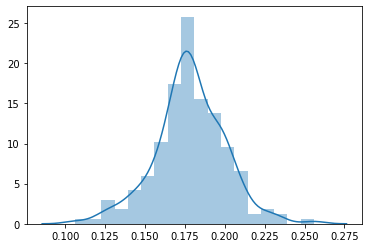

In [17]:
sns.distplot(r)

In [18]:
x = np.mean(shuf_lesioned_accuracy, axis = 0)
y = np.mean(shuf_lesioned_var_exp, axis = 0)

In [19]:
sp.stats.spearmanr(x,y)

SpearmanrResult(correlation=-0.0029205730143253587, pvalue=0.9672605501379307)

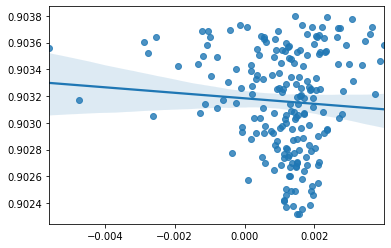

In [20]:
sns.regplot(x = x, y = y)

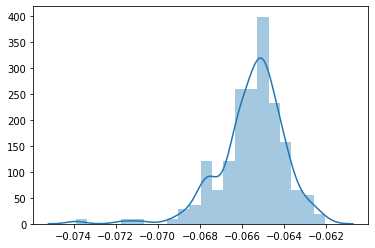

In [21]:
sns.distplot(np.min(accuracy_delta, axis = 0))

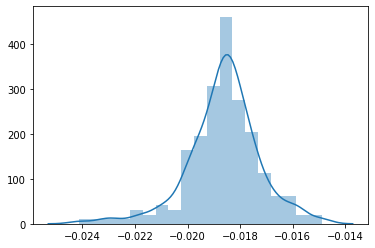

In [22]:
sns.distplot(np.max(accuracy_delta, axis = 0))

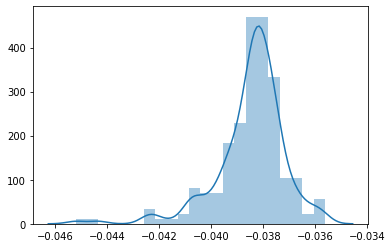

In [23]:
sns.distplot(np.mean(accuracy_delta, axis = 0))